In [2]:
!pip install SQLAlchemy Faker
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import random
from faker import Faker

# Initialize Faker
fake = Faker()

# 1. Generate Campaigns Table
def generate_campaigns(n=10):
    campaigns = []
    for i in range(1, n+1):
        campaigns.append({
            'campaign_id': i,
            'campaign_name': fake.catch_phrase(),
            'start_date': fake.date_between(start_date='-2y', end_date='today'),
            'budget': round(random.uniform(1000, 10000), 2)
        })
    return pd.DataFrame(campaigns)

# 2. Generate Customers Table
def generate_customers(n=100):
    customers = []
    for i in range(1, n+1):
        customers.append({
            'customer_id': i,
            'customer_name': fake.name(),
            'age': random.randint(18, 70),
            'city': fake.city()
        })
    return pd.DataFrame(customers)

# 3. Generate Campaign Results Table
def generate_campaign_results(customers, campaigns):
    results = []
    for customer_id in customers['customer_id']:
        for campaign_id in random.sample(list(campaigns['campaign_id']), k=random.randint(1, 5)):
            results.append({
                'result_id': f"{customer_id}_{campaign_id}",
                'campaign_id': campaign_id,
                'customer_id': customer_id,
                'opened': random.choice([0, 1]),
                'clicked': random.choice([0, 1]),
                'purchased': random.choice([0, 1])
            })
    return pd.DataFrame(results)

# Generate Data
campaigns_df = generate_campaigns(10)
customers_df = generate_customers(100)
campaign_results_df = generate_campaign_results(customers_df, campaigns_df)

# 4. Create SQLite database and save tables
engine = create_engine('sqlite:///marketing_campaigns.db')

campaigns_df.to_sql('campaigns', con=engine, if_exists='replace', index=False)
customers_df.to_sql('customers', con=engine, if_exists='replace', index=False)
campaign_results_df.to_sql('campaign_results', con=engine, if_exists='replace', index=False)

print("Database 'marketing_campaigns.db' created with tables: campaigns, customers, campaign_results.")

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [Faker]32m1/2 [Faker]
Database 'marketing_campaigns.db' created with tables: campaigns, customers, campaign_results.


In [3]:
# Step 2: Connect to Database and Run SQL Analysis

import pandas as pd
from sqlalchemy import create_engine

# Connect to the database
engine = create_engine('sqlite:///marketing_campaigns.db')

# 1. Check all campaigns
query_campaigns = """
SELECT * FROM campaigns;
"""
campaigns = pd.read_sql(query_campaigns, engine)
print("Campaigns Data:")
display(campaigns)

# 2. Check the numner of clients
query_customers_count = """
SELECT COUNT(*) as total_customers
FROM customers;
"""
total_customers = pd.read_sql(query_customers_count, engine)
print("Total Customers:")
display(total_customers)

# 3. Open rate и click rate for campaigns
query_open_click_rate = """
SELECT 
    c.campaign_id,
    ca.campaign_name,
    ROUND(SUM(c.opened)*1.0/COUNT(c.customer_id)*100, 2) AS open_rate_percent,
    ROUND(SUM(c.clicked)*1.0/COUNT(c.customer_id)*100, 2) AS click_rate_percent
FROM campaign_results c
JOIN campaigns ca ON c.campaign_id = ca.campaign_id
GROUP BY c.campaign_id, ca.campaign_name
ORDER BY open_rate_percent DESC;
"""
open_click_rates = pd.read_sql(query_open_click_rate, engine)
print("Open Rate and Click Rate per Campaign:")
display(open_click_rates)

# 4. top sellers
query_best_campaigns = """
SELECT 
    ca.campaign_name,
    COUNT(cr.purchased) AS total_purchases
FROM campaign_results cr
JOIN campaigns ca ON cr.campaign_id = ca.campaign_id
WHERE cr.purchased = 1
GROUP BY ca.campaign_name
ORDER BY total_purchases DESC
LIMIT 5;
"""
best_campaigns = pd.read_sql(query_best_campaigns, engine)
print("Top 5 Campaigns by Purchases:")
display(best_campaigns)

# 5. Top active clients
query_active_customers = """
SELECT 
    cu.customer_name,
    COUNT(cr.campaign_id) AS campaigns_participated
FROM campaign_results cr
JOIN customers cu ON cr.customer_id = cu.customer_id
GROUP BY cu.customer_name
ORDER BY campaigns_participated DESC
LIMIT 5;
"""
active_customers = pd.read_sql(query_active_customers, engine)
print("Top 5 Most Active Customers:")
display(active_customers)


Campaigns Data:


,campaign_id,campaign_name,start_date,budget
0,1,Customer-focused eco-centric policy,2024-02-03,7615.76
1,2,Visionary context-sensitive capability,2023-07-07,5964.18
2,3,Stand-alone maximized service-desk,2024-07-22,7143.25
3,4,Virtual zero administration leverage,2025-02-17,6926.59
4,5,Monitored zero-defect circuit,2024-04-01,6035.75
5,6,Focused system-worthy conglomeration,2025-02-19,7223.56
6,7,Multi-channeled exuding standardization,2025-02-15,9275.50
7,8,Reactive multi-state methodology,2025-03-28,2130.30
8,9,Front-line motivating orchestration,2024-03-26,4130.82
9,10,Progressive leadingedge function,2024-12-09,7701.99


Total Customers:


,total_customers
0,100


Open Rate and Click Rate per Campaign:


,campaign_id,campaign_name,open_rate_percent,click_rate_percent
0,5,Monitored zero-defect circuit,63.33,36.67
1,7,Multi-channeled exuding standardization,62.96,51.85
2,2,Visionary context-sensitive capability,57.14,39.29
3,9,Front-line motivating orchestration,50.00,44.12
4,1,Customer-focused eco-centric policy,48.15,44.44
5,3,Stand-alone maximized service-desk,45.45,54.55
6,4,Virtual zero administration leverage,41.38,51.72
7,8,Reactive multi-state methodology,41.18,52.94
8,10,Progressive leadingedge function,36.84,55.26
9,6,Focused system-worthy conglomeration,35.48,67.74


Top 5 Campaigns by Purchases:


,campaign_name,total_purchases
0,Progressive leadingedge function,24
1,Front-line motivating orchestration,22
2,Reactive multi-state methodology,19
3,Customer-focused eco-centric policy,14
4,Multi-channeled exuding standardization,13


Top 5 Most Active Customers:


,customer_name,campaigns_participated
0,Victoria Levine,5
1,Tiffany Schroeder,5
2,Samuel Rocha,5
3,Ronald Anderson,5
4,Regina Berg,5


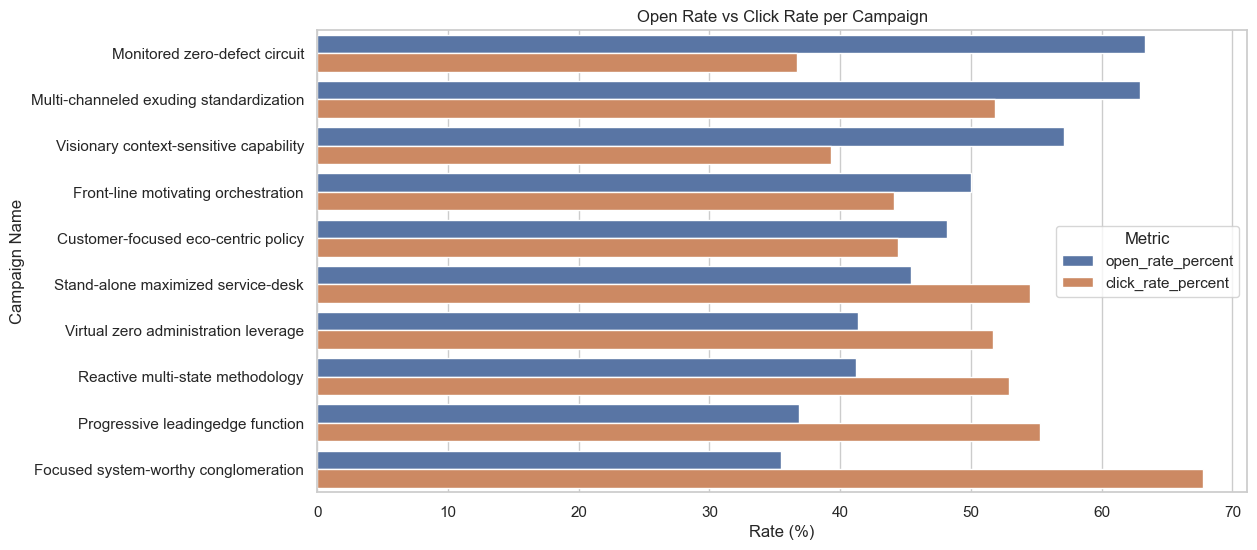

/var/folders/_q/gpzxm6q14vz_lsv0vzj04j240000gn/T/ipykernel_8648/3888456756.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_purchases", y="campaign_name", data=best_campaigns, palette="Blues_d")


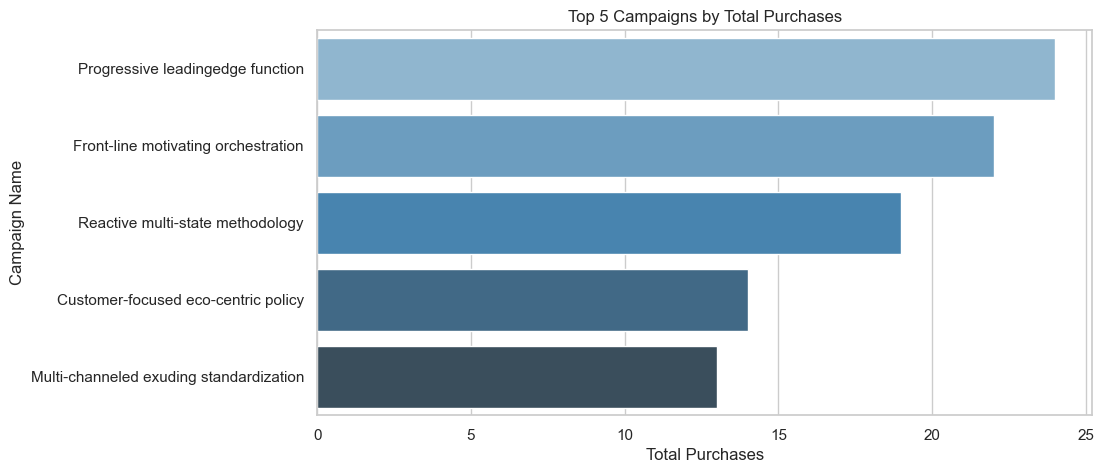

/var/folders/_q/gpzxm6q14vz_lsv0vzj04j240000gn/T/ipykernel_8648/3888456756.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="campaigns_participated", y="customer_name", data=active_customers, palette="Greens_d")


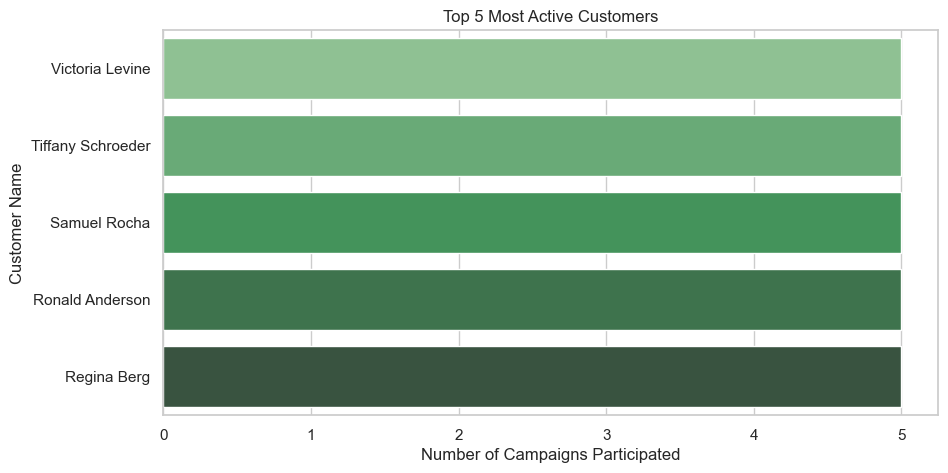

In [4]:
# Step 3: Visualize Key Insights

import matplotlib.pyplot as plt
import seaborn as sns

# Graphics
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Bar-chart for Open Rate и Click Rate by campaigns
open_click_melted = open_click_rates.melt(id_vars=["campaign_name"], 
                                          value_vars=["open_rate_percent", "click_rate_percent"],
                                          var_name="metric", value_name="rate")

plt.figure(figsize=(12, 6))
sns.barplot(x="rate", y="campaign_name", hue="metric", data=open_click_melted)
plt.title("Open Rate vs Click Rate per Campaign")
plt.xlabel("Rate (%)")
plt.ylabel("Campaign Name")
plt.legend(title="Metric")
plt.show()

# 2. Bar-chart best campaigns in sells
plt.figure(figsize=(10, 5))
sns.barplot(x="total_purchases", y="campaign_name", data=best_campaigns, palette="Blues_d")
plt.title("Top 5 Campaigns by Total Purchases")
plt.xlabel("Total Purchases")
plt.ylabel("Campaign Name")
plt.show()

# 3. Bar-chart for top clients
plt.figure(figsize=(10, 5))
sns.barplot(x="campaigns_participated", y="customer_name", data=active_customers, palette="Greens_d")
plt.title("Top 5 Most Active Customers")
plt.xlabel("Number of Campaigns Participated")
plt.ylabel("Customer Name")
plt.show()


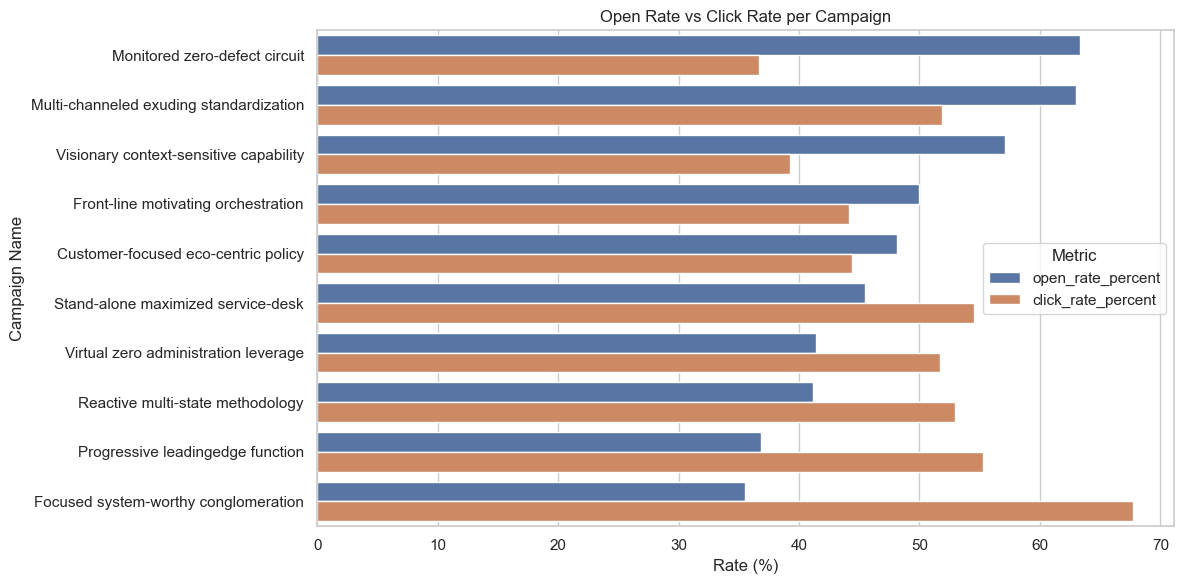

/var/folders/_q/gpzxm6q14vz_lsv0vzj04j240000gn/T/ipykernel_8648/3650046414.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_purchases", y="campaign_name", data=best_campaigns, palette="Blues_d")


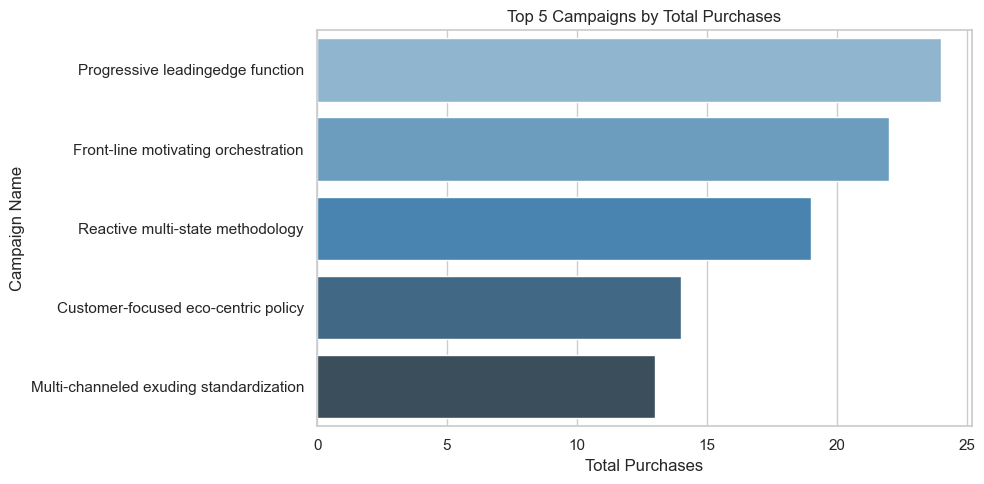

/var/folders/_q/gpzxm6q14vz_lsv0vzj04j240000gn/T/ipykernel_8648/3650046414.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="campaigns_participated", y="customer_name", data=active_customers, palette="Greens_d")


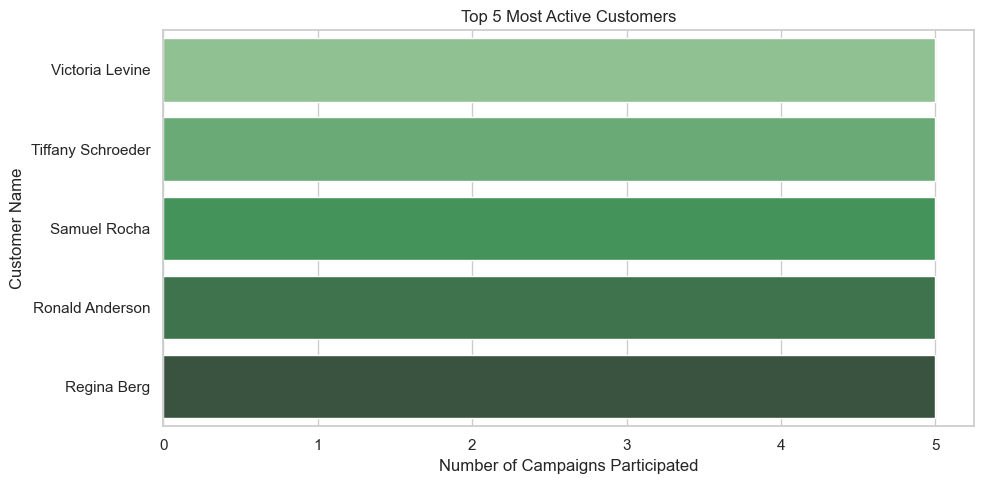

In [5]:
import os
os.makedirs("images", exist_ok=True)
# Save Open vs Click Rates
plt.figure(figsize=(12, 6))
sns.barplot(x="rate", y="campaign_name", hue="metric", data=open_click_melted)
plt.title("Open Rate vs Click Rate per Campaign")
plt.xlabel("Rate (%)")
plt.ylabel("Campaign Name")
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("images/open_vs_click_rate.png")
plt.show()

# Save Top Campaigns
plt.figure(figsize=(10, 5))
sns.barplot(x="total_purchases", y="campaign_name", data=best_campaigns, palette="Blues_d")
plt.title("Top 5 Campaigns by Total Purchases")
plt.xlabel("Total Purchases")
plt.ylabel("Campaign Name")
plt.tight_layout()
plt.savefig("images/top_campaigns.png")
plt.show()

# Save Top Customers
plt.figure(figsize=(10, 5))
sns.barplot(x="campaigns_participated", y="customer_name", data=active_customers, palette="Greens_d")
plt.title("Top 5 Most Active Customers")
plt.xlabel("Number of Campaigns Participated")
plt.ylabel("Customer Name")
plt.tight_layout()
plt.savefig("images/top_customers.png")
plt.show()


In [6]:
# Step 4: Funnel Analysis

# SQL for funnel steps
query_funnel = """
SELECT 
    COUNT(DISTINCT customer_id) AS delivered,
    SUM(opened) AS opened,
    SUM(clicked) AS clicked,
    SUM(purchased) AS purchased
FROM campaign_results;
"""

funnel_data = pd.read_sql(query_funnel, engine)
funnel_data = funnel_data.T.reset_index()
funnel_data.columns = ['Stage', 'Count']

print("Funnel Data:")
display(funnel_data)


Funnel Data:


,Stage,Count
0,delivered,100
1,opened,143
2,clicked,150
3,purchased,151


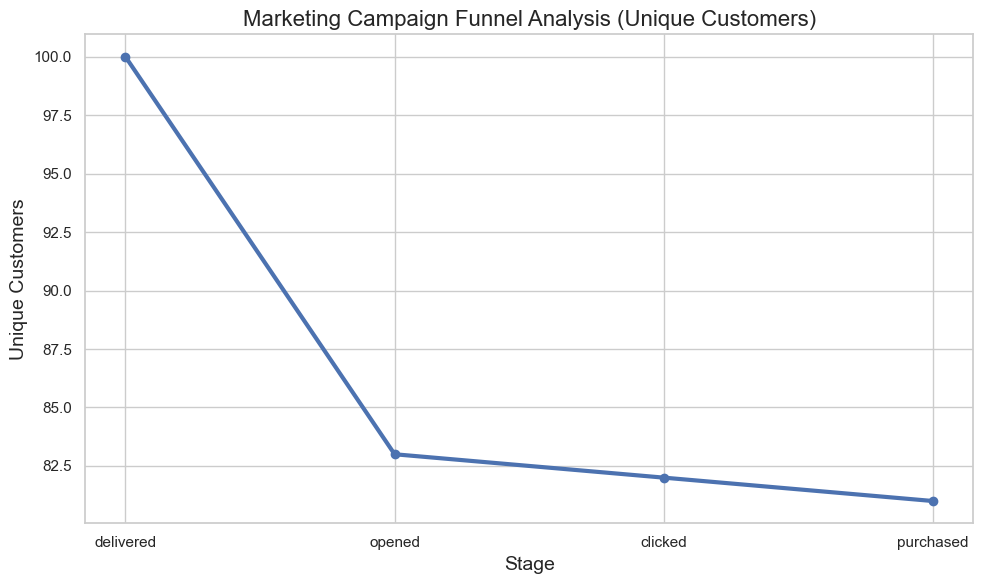

In [8]:
# Function analysis
query_funnel_fixed = """
SELECT
    (SELECT COUNT(DISTINCT customer_id) FROM campaign_results) AS delivered,
    (SELECT COUNT(DISTINCT customer_id) FROM campaign_results WHERE opened = 1) AS opened,
    (SELECT COUNT(DISTINCT customer_id) FROM campaign_results WHERE clicked = 1) AS clicked,
    (SELECT COUNT(DISTINCT customer_id) FROM campaign_results WHERE purchased = 1) AS purchased
"""

funnel_data = pd.read_sql(query_funnel_fixed, engine)
funnel_data = funnel_data.T.reset_index()
funnel_data.columns = ['Stage', 'Count']

# Funnel Chart
stages = ["delivered", "opened", "clicked", "purchased"]
funnel_data = funnel_data.set_index('Stage').loc[stages].reset_index()

plt.figure(figsize=(10, 6))
plt.plot(funnel_data['Stage'], funnel_data['Count'], marker='o', linewidth=3)
plt.title('Marketing Campaign Funnel Analysis (Unique Customers)', fontsize=16)
plt.xlabel('Stage', fontsize=14)
plt.ylabel('Unique Customers', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("images/funnel_analysis.png")
plt.show()


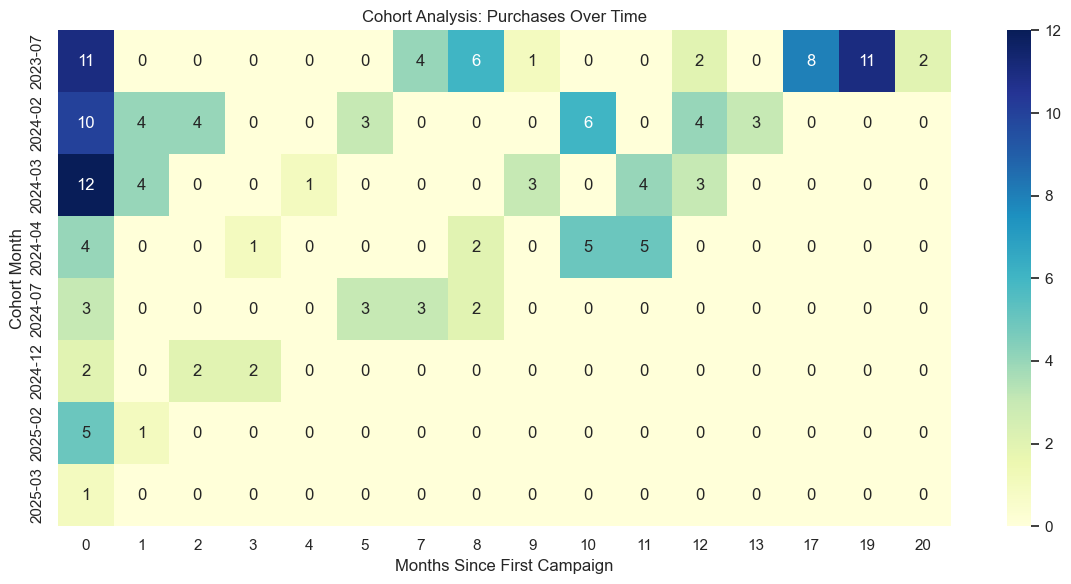

In [10]:
# Step 5: Cohort Analysis - Prepare cohort data

query_cohort_data = """
SELECT 
    cr.customer_id,
    cr.campaign_id,
    cr.opened,
    cr.clicked,
    cr.purchased,
    MIN(ca.start_date) OVER (PARTITION BY cr.customer_id) AS cohort_date,
    ca.start_date AS campaign_date
FROM campaign_results cr
JOIN campaigns ca ON cr.campaign_id = ca.campaign_id
"""

# Upload data
df_cohort = pd.read_sql(query_cohort_data, engine)

# Dates to periods
df_cohort['cohort_month'] = pd.to_datetime(df_cohort['cohort_date']).dt.to_period('M')
df_cohort['campaign_month'] = pd.to_datetime(df_cohort['campaign_date']).dt.to_period('M')

# Lyfecycle
df_cohort['cohort_index'] = (df_cohort['campaign_month'] - df_cohort['cohort_month']).apply(lambda x: x.n)

# Groups how many customers in cohort
cohort_pivot = df_cohort[df_cohort['purchased'] == 1].groupby(
    ['cohort_month', 'cohort_index']
).agg({'customer_id': 'nunique'}).reset_index()

# Pivot-table
cohort_table = cohort_pivot.pivot(index='cohort_month', columns='cohort_index', values='customer_id')
cohort_table.fillna(0, inplace=True)

# Visualize
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_table, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Cohort Analysis: Purchases Over Time')
plt.xlabel('Months Since First Campaign')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.savefig('images/cohort_heatmap.png')
plt.show()


,customer_id,recency,frequency,monetary
0,1,0,3,3
1,2,41,1,1
2,3,37,2,2
3,4,109,2,2
4,5,0,2,2


,customer_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
0,1,0,3,3,4,4,2,442,10
44,58,0,5,5,4,4,2,442,10
53,68,0,5,5,4,4,2,442,10
49,64,0,4,4,4,4,2,442,10
7,9,37,3,3,4,4,2,442,10


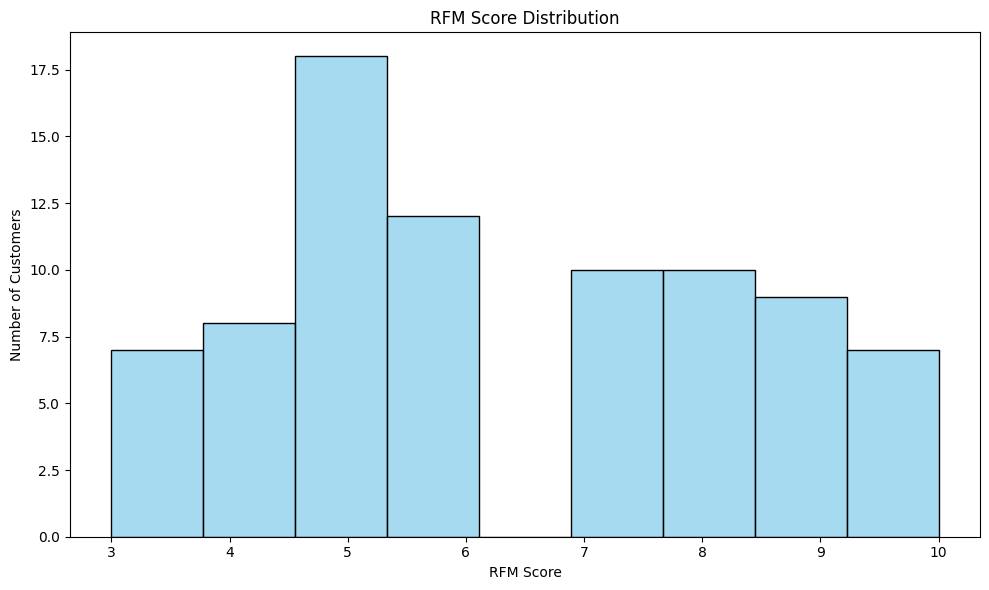

In [5]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///marketing_campaigns.db')
df_rfm = pd.read_sql(query_rfm, engine)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

query_rfm = """
SELECT 
    cr.customer_id,
    MAX(ca.start_date) AS last_purchase_date,
    COUNT(cr.purchased) AS frequency,
    SUM(cr.purchased) AS monetary
FROM campaign_results cr
JOIN campaigns ca ON cr.campaign_id = ca.campaign_id
WHERE cr.purchased = 1
GROUP BY cr.customer_id
"""

# RFM table
df_rfm = pd.read_sql(query_rfm, engine)
df_rfm['last_purchase_date'] = pd.to_datetime(df_rfm['last_purchase_date'])

# Date Setup
latest_date = df_rfm['last_purchase_date'].max()

# Count Recency
df_rfm['recency'] = (latest_date - df_rfm['last_purchase_date']).dt.days

df_rfm = df_rfm[['customer_id', 'recency', 'frequency', 'monetary']]
display(df_rfm.head())

# Quantile segmentation
df_rfm['R_score'] = pd.qcut(df_rfm['recency'], 4, labels=[4, 3, 2, 1])
df_rfm['F_score'] = pd.qcut(df_rfm['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Quantiles for Monetary
try:
    df_rfm['M_score'] = pd.qcut(df_rfm['monetary'], 4, labels=[1, 2, 3, 4])
except ValueError:
    # ЕIf bines are less than 4
    unique_bins = pd.qcut(df_rfm['monetary'], 4, duplicates='drop')
    n_bins = unique_bins.cat.categories.size
    df_rfm['M_score'] = pd.qcut(df_rfm['monetary'], q=n_bins, labels=list(range(1, n_bins + 1)))


# RFM Segment
df_rfm['RFM_Segment'] = df_rfm['R_score'].astype(str) + df_rfm['F_score'].astype(str) + df_rfm['M_score'].astype(str)
df_rfm['RFM_Score'] = df_rfm[['R_score', 'F_score', 'M_score']].astype(int).sum(axis=1)

display(df_rfm.sort_values('RFM_Score', ascending=False).head())

# Visualize
plt.figure(figsize=(10, 6))
sns.histplot(df_rfm['RFM_Score'], bins=9, kde=False, color='skyblue')
plt.title('RFM Score Distribution')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig('images/rfm_segmentation.png')
plt.show()

